In [1]:
#########################
### Paramaters to set ###
#########################
save_path = 'model_cut.h5'
crop_top = 60
crop_bottom = 20
early_stopping_min_delta = 0.0003,
early_stopping_patience=5

################
### Imports ###
################
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Input, Cropping2D, Dropout, Activation
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG16

#################
### Load data ###
#################
driving_log = pd.read_csv('data/driving_log.csv')

def update_path(source_path, new_path_prefix):
    filename = source_path.split('/')[-1]
    return new_path_prefix + filename

num_in = len(driving_log)
X_train = np.zeros((6*num_in, 160, 320, 3), dtype=np.uint8)  # set up array in advance to save memory
y_train = np.zeros(6*num_in, dtype=float)

for i, (img_path_orig, steering_angle) in enumerate(zip(driving_log['center'], driving_log['steering'])):
    img_path = update_path(img_path_orig, 'data/IMG/')
    image = plt.imread(img_path)
    X_train[2*i] = image
    y_train[2*i] = steering_angle
    X_train[2*i+1] = np.fliplr(image)
    y_train[2*i+1] = -steering_angle
    
for i, (img_path_orig, steering_angle) in enumerate(zip(driving_log['left'], driving_log['steering'])):
    img_path = update_path(img_path_orig, 'data/IMG/')
    image = plt.imread(img_path)
    steering_angle += 0.25  # correct for view from left side
    X_train[2*num_in + 2*i] = image
    y_train[2*num_in + 2*i] = steering_angle
    X_train[2*num_in + 2*i+1] = np.fliplr(image)
    y_train[2*num_in + 2*i+1] = -steering_angle
    
for i, (img_path_orig, steering_angle) in enumerate(zip(driving_log['right'], driving_log['steering'])):
    img_path = update_path(img_path_orig, 'data/IMG/')
    image = plt.imread(img_path)
    steering_angle -= 0.25  # correct for view from right side
    X_train[4*num_in + 2*i] = image
    y_train[4*num_in + 2*i] = steering_angle
    X_train[4*num_in + 2*i+1] = np.fliplr(image)
    y_train[4*num_in + 2*i+1] = -steering_angle

def high_value_emphasizing_loss(y_true, y_pred):
    weighted_squared_difference = (y_true - y_pred)**2 * (1 + 100*np.abs(y_true)) # what if true = 0?
    return weighted_squared_difference

####################
### Set up model ###
####################

stopper = EarlyStopping(monitor='val_loss', min_delta=0.0003, patience=5)
checkpoint = ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)

# custom loss function to put higher emphasis on large steering angles for which we have relatively little data
def high_value_emphasizing_loss(y_true, y_pred):
    weighted_squared_difference = (y_true - y_pred)**2 * (1 + 100*np.abs(y_true)) # what if true = 0?
    return weighted_squared_difference

# load pretrained network
pretrained = VGG16(weights='imagenet', include_top=False,
                   input_shape=(160-crop_top-crop_bottom, 320-0, 3))
for layer in pretrained.layers:
    layer.trainable = False

# cut off the top four pretrained layers
# (when using pop the model could ne be saved. Hence, the method below. https://github.com/tensorflow/tensorflow/issues/22479)
pretrained_cut = Sequential()
for layer in pretrained.layers[:-4]:
    pretrained_cut.add(layer)

inp = Input(shape=(160,320,3))
x = Cropping2D(cropping=((crop_top,crop_bottom), (0,0)))(inp)
x = Lambda(lambda x: (x / 255.0) - 0.5)(x)
x = pretrained_cut(x)
x = Flatten()(x)
x = Dropout(rate=0.4)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(rate=0.25)(x) # higher dropout close to regression result seemed to lead to problems
x = Dense(100)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
model = Model(inputs = inp, outputs=x)

model.compile(loss=high_value_emphasizing_loss, optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=50,
                           batch_size=128, callbacks=[stopper, checkpoint])

Using TensorFlow backend.
/opt/miniconda3/envs/car2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/car2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/car2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/car2/lib/python3.5/site-pa







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 38572 samples, validate on 9644 samples
Epoch 1/50
38572/38572 [==============================] - 77s 2ms/step - loss: 1421.6185 - val_loss: 6.6894
Epoch 2/50
38572/38572 [==============================] - 75s 2ms/step - loss: 24.2759 - val_loss: 1.3585
Epoch 3/50
38572/38572 [==============================] - 74s 2ms/step - loss: 10.0856 - val_loss: 1.1109
Epoch 4/50
38572/38572 [==============================] - 75s 2ms/step - loss: 5.3392 - val_loss: 1.0790
Epoch 5/50
38572/38572 [==============================] - 74s 2ms/step - loss: 3.4912 - val_loss: 1.0971
Epoch 6/50
38572/38572 [==============================] - 74s 2ms/step - loss: 2.4647 - val_loss: 0.9983
Epoch 7/50
38572/38572 [==============================] - 76s 2ms/step - loss: 1.7853 - val_loss: 0.

In [4]:
import json

with open('history_object_cut.json', 'w') as fp:
    json.dump(history_object.history, fp)

In [6]:
with open('history_object_cut.json', 'r') as fp:
    hdata = json.load(fp)

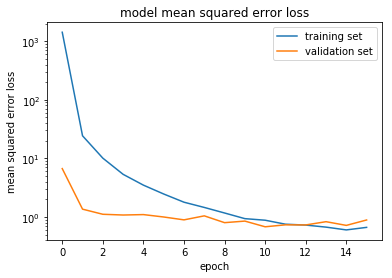

In [9]:
plt.plot(hdata['loss'])
plt.plot(hdata['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
# plt.ylim([0, 1.5])
plt.yscale('log')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
# plt.savefig("loss_evolution.png")

In [1]:
import numpy as np
import pandas as pd
from scipy import ndimage
import matplotlib.pyplot as plt

# import warnings
# warnings.filterwarnings('ignore')

def update_path(source_path, new_path_prefix):
    filename = source_path.split('/')[-1]
    return new_path_prefix + filename

driving_log = pd.read_csv('data/driving_log.csv')

In [2]:
num_in = len(driving_log)
X_train = np.zeros((6*num_in, 160, 320, 3), dtype=np.uint8)
y_train = np.zeros(6*num_in, dtype=float)

for i, (img_path_orig, steering_angle) in enumerate(zip(driving_log['center'], driving_log['steering'])):
    img_path = update_path(img_path_orig, 'data/IMG/')
    image = plt.imread(img_path)
    X_train[2*i] = image
    y_train[2*i] = steering_angle
    X_train[2*i+1] = np.fliplr(image)
    y_train[2*i+1] = -steering_angle
    
for i, (img_path_orig, steering_angle) in enumerate(zip(driving_log['left'], driving_log['steering'])):
    img_path = update_path(img_path_orig, 'data/IMG/')
    image = plt.imread(img_path)
    steering_angle += 0.25
    X_train[2*num_in + 2*i] = image
    y_train[2*num_in + 2*i] = steering_angle
    X_train[2*num_in + 2*i+1] = np.fliplr(image)
    y_train[2*num_in + 2*i+1] = -steering_angle
    
for i, (img_path_orig, steering_angle) in enumerate(zip(driving_log['right'], driving_log['steering'])):
    img_path = update_path(img_path_orig, 'data/IMG/')
    image = plt.imread(img_path)
    steering_angle -= 0.25
    X_train[4*num_in + 2*i] = image
    y_train[4*num_in + 2*i] = steering_angle
    X_train[4*num_in + 2*i+1] = np.fliplr(image)
    y_train[4*num_in + 2*i+1] = -steering_angle
    

In [11]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Input, Cropping2D, Dropout, Activation#, Concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications import VGG19, VGG16, InceptionV3, ResNet50
 
save_path = 'model_cut.h5'
early_stopping_min_delta =0.0003,
early_stopping_patience=3

dropout_rate = 0.4
crop_top = 60
crop_bottom = 20
split_left_right = 140
stopper = EarlyStopping(monitor='val_loss', min_delta=0.0003, patience=3)
checkpoint = ModelCheckpoint(filepath=save_path, monitor='val_loss', save_best_only=True)

def high_value_emphasizing_loss(y_true, y_pred):
    weighted_squared_difference = (y_true - y_pred)**2 * (1 + 100*np.abs(y_true)) # what if true = 0?
    return weighted_squared_difference

pretrained = VGG16(weights='imagenet', include_top=False,
                   input_shape=(160-crop_top-crop_bottom, 320-0, 3))
for layer in pretrained.layers:
    layer.trainable = False
    
pretrained_cut = Sequential()  # https://github.com/tensorflow/tensorflow/issues/22479
for layer in pretrained.layers[:-4]:
    pretrained_cut.add(layer)

inp = Input(shape=(160,320,3))
x = Cropping2D(cropping=((crop_top,crop_bottom), (0,0)))(inp)
x = Lambda(lambda x: (x / 255.0) - 0.5)(x)
x = pretrained_cut(x)
x = Flatten()(x)
x = Dropout(rate=0.4)(x)
x = Dense(256)(x)
x = Activation('relu')(x)
x = Dropout(rate=0.2)(x)
x = Dense(100)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
model = Model(inputs = inp, outputs=x)

model.compile(loss=high_value_emphasizing_loss, optimizer='adam')
history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=30,
                           batch_size=256, callbacks=[stopper, checkpoint])


Train on 38572 samples, validate on 9644 samples
Epoch 1/30
38572/38572 [==============================] - 69s 2ms/step - loss: 4326.5775 - val_loss: 3.1926
Epoch 2/30
38572/38572 [==============================] - 70s 2ms/step - loss: 82.2666 - val_loss: 5.5677
Epoch 3/30
38572/38572 [==============================] - 70s 2ms/step - loss: 35.4454 - val_loss: 2.2240
Epoch 4/30
38572/38572 [==============================] - 70s 2ms/step - loss: 20.6031 - val_loss: 1.8937
Epoch 5/30
38572/38572 [==============================] - 69s 2ms/step - loss: 13.4207 - val_loss: 1.5090
Epoch 6/30
38572/38572 [==============================] - 70s 2ms/step - loss: 9.6103 - val_loss: 1.2249
Epoch 7/30
38572/38572 [==============================] - 69s 2ms/step - loss: 7.1974 - val_loss: 1.2275
Epoch 8/30
38572/38572 [==============================] - 69s 2ms/step - loss: 5.5787 - val_loss: 1.1839
Epoch 9/30
38572/38572 [==============================] - 70s 2ms/step - loss: 4.4157 - val_loss: 1.1498

Using TensorFlow backend.
/opt/miniconda3/envs/car2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/miniconda3/envs/car2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/miniconda3/envs/car2/lib/python3.5/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/miniconda3/envs/car2/lib/python3.5/site-pa







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 38572 samples, validate on 9644 samples
Epoch 1/50
38572/38572 [==============================] - 77s 2ms/step - loss: 2573.0269 - val_loss: 15.9397
Epoch 2/50
38572/38572 [==============================] - 74s 2ms/step - loss: 21.0205 - val_loss: 2.9904
Epoch 3/50
38572/38572 [==============================] - 75s 2ms/step - loss: 7.3504 - val_loss: 2.4694


In [ ]:
Train on 38572 samples, validate on 9644 samples
Epoch 1/30
38572/38572 [==============================] - 77s 2ms/step - loss: 4.8215 - val_loss: 0.9179
Epoch 2/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.6729 - val_loss: 0.8226
Epoch 3/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.5343 - val_loss: 0.9063
Epoch 4/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.4794 - val_loss: 0.8309
Epoch 5/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.4526 - val_loss: 0.7689
Epoch 6/30
38572/38572 [==============================] - 72s 2ms/step - loss: 0.4235 - val_loss: 0.7591
Epoch 7/30
38572/38572 [==============================] - 72s 2ms/step - loss: 0.4025 - val_loss: 0.7264
Epoch 8/30
38572/38572 [==============================] - 73s 2ms/step - loss: 0.3859 - val_loss: 0.7655
Epoch 9/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.3632 - val_loss: 0.7488
Epoch 10/30
38572/38572 [==============================] - 71s 2ms/step - loss: 0.3517 - val_loss: 0.7611

In [ ]:
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
# plt.ylim([0, 1.5])
pyplot.yscale('log')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
plt.savefig("loss_evolution.png")

In [27]:
pre.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 80, 180, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 180, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 90, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 90, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 90, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 45, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 20, 45, 256)       295168    
__________

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_2 (Cropping2D)    (None, 80, 320, 3)        0         
_________________________________________________________________
lambda_2 (Lambda)            (None, 80, 320, 3)        0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 5, 20, 512)        7635264   
_________________________________________________________________
flatten_2 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 51200)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               13107456  
__________

In [4]:
from keras.models import load_model

In [12]:
pretrained.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 80, 320, 3)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 80, 320, 64)       1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 80, 320, 64)       36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 40, 160, 64)       0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 40, 160, 128)      73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 40, 160, 128)      147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 20, 80, 128)       0         
__________